In [38]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error 
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split



In [2]:
df=pd.read_csv("dataset.csv")
df.head()

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837


In [3]:
df.shape

(3454, 15)

In [4]:
df.columns

Index(['device_brand', 'os', 'screen_size', '4g', '5g', 'rear_camera_mp',
       'front_camera_mp', 'internal_memory', 'ram', 'battery', 'weight',
       'release_year', 'days_used', 'normalized_used_price',
       'normalized_new_price'],
      dtype='object')

In [5]:
df.device_brand.value_counts()

device_brand
Others        502
Samsung       341
Huawei        251
LG            201
Lenovo        171
ZTE           140
Xiaomi        132
Oppo          129
Asus          122
Alcatel       121
Micromax      117
Vivo          117
Honor         116
HTC           110
Nokia         106
Motorola      106
Sony           86
Meizu          62
Gionee         56
Acer           51
XOLO           49
Panasonic      47
Realme         41
Apple          39
Lava           36
Celkon         33
Spice          30
Karbonn        29
BlackBerry     22
OnePlus        22
Microsoft      22
Coolpad        22
Google         15
Infinix        10
Name: count, dtype: int64

In [6]:
df.isnull().sum()
df.duplicated().sum()

np.int64(0)

# EDA


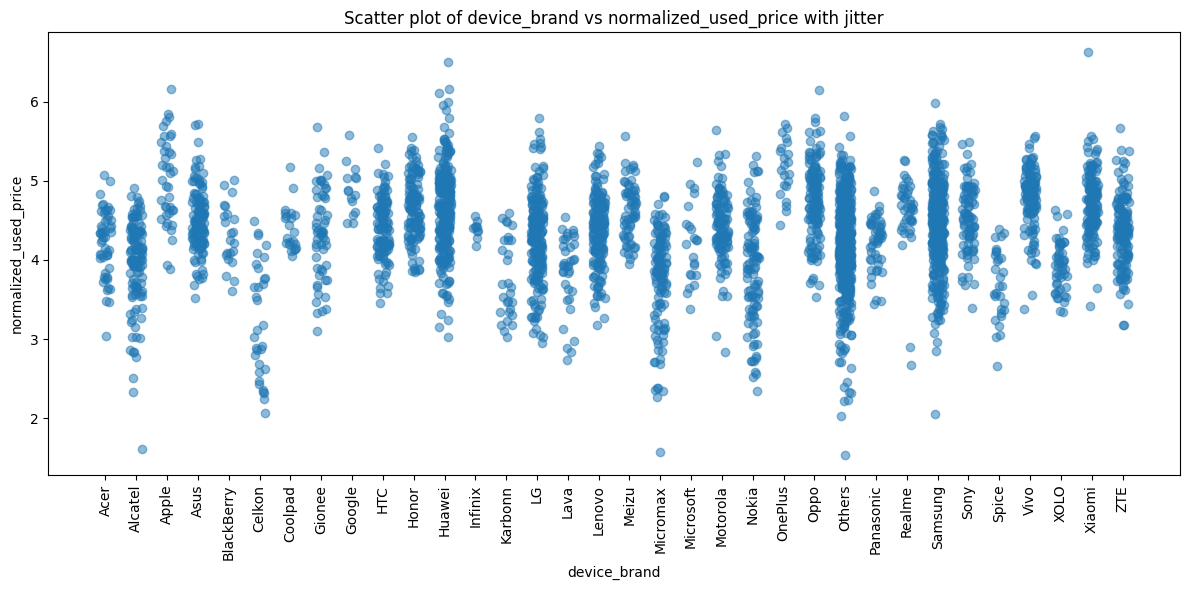

In [7]:
# Add jitter to categorical x-axis
brands = df.device_brand.astype('category').cat.codes
jitter = np.random.uniform(-0.2, 0.2, size=len(brands))
plt.figure(figsize=(12,6))
plt.scatter(brands + jitter, df.normalized_used_price, alpha=0.5)
plt.xticks(ticks=np.unique(brands), labels=df.device_brand.astype('category').cat.categories, rotation=90)
plt.xlabel('device_brand')
plt.ylabel('normalized_used_price')
plt.title('Scatter plot of device_brand vs normalized_used_price with jitter')
plt.tight_layout()
plt.show()

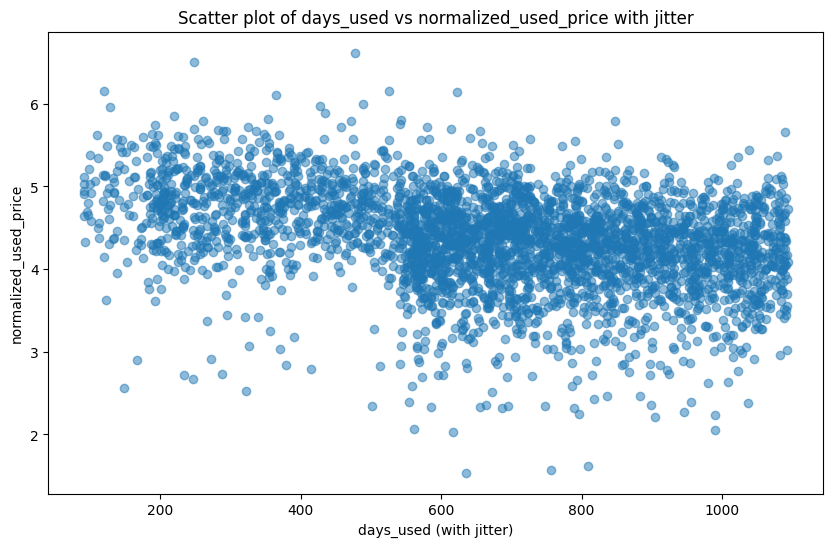

In [8]:
plt.figure(figsize=(10,6))
plt.scatter(df.days_used + jitter, df.normalized_used_price, alpha=0.5)
plt.xlabel('days_used (with jitter)')
plt.ylabel('normalized_used_price')
plt.title('Scatter plot of days_used vs normalized_used_price with jitter')
plt.show()

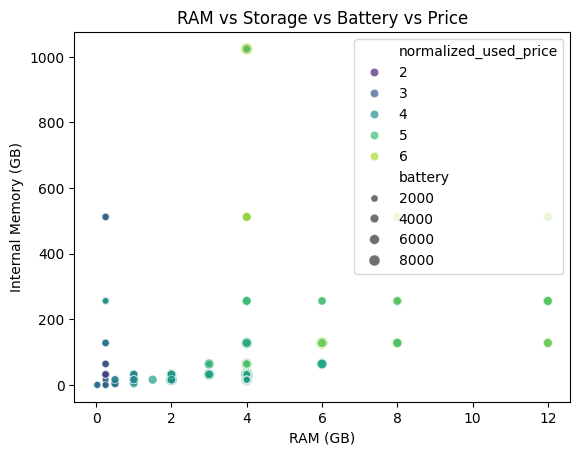

In [9]:
sns.scatterplot(x='ram', y='internal_memory', size='battery', hue='normalized_used_price', 
                data=df, palette='viridis', alpha=0.7)
plt.title("RAM vs Storage vs Battery vs Price")
plt.xlabel("RAM (GB)")
plt.ylabel("Internal Memory (GB)")
plt.show()

In [10]:
df.sample(5)

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
1968,Motorola,Android,15.29,yes,no,12.0,12.0,64.0,4.0,5000.0,205.0,2018,373,4.673296,5.593596
241,HTC,Android,15.29,yes,no,13.0,16.0,32.0,3.0,3850.0,170.0,2019,194,4.829033,5.185652
2033,Nokia,Android,15.90,yes,no,13.0,5.0,32.0,4.0,4000.0,181.0,2019,317,4.579339,4.861284
1328,Huawei,Android,12.83,yes,no,16.0,8.0,32.0,4.0,3340.0,160.0,2016,707,4.859890,5.861669
202,Xiaomi,Android,16.23,yes,no,12.0,32.0,64.0,6.0,4030.0,179.0,2019,406,4.886281,5.568192


In [11]:
df.os.value_counts()

os
Android    3214
Others      137
Windows      67
iOS          36
Name: count, dtype: int64

In [12]:
df.describe()

,screen_size,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
count,3454.000000,3275.000000,3452.000000,3450.000000,3450.000000,3448.000000,3447.000000,3454.000000,3454.000000,3454.000000,3454.000000
mean,13.713115,9.460208,6.554229,54.573099,4.036122,3133.402697,182.751871,2015.965258,674.869716,4.364712,5.233107
std,3.805280,4.815461,6.970372,84.972371,1.365105,1299.682844,88.413228,2.298455,248.580166,0.588914,0.683637
min,5.080000,0.080000,0.000000,0.010000,0.020000,500.000000,69.000000,2013.000000,91.000000,1.536867,2.901422
25%,12.700000,5.000000,2.000000,16.000000,4.000000,2100.000000,142.000000,2014.000000,533.500000,4.033931,4.790342
50%,12.830000,8.000000,5.000000,32.000000,4.000000,3000.000000,160.000000,2015.500000,690.500000,4.405133,5.245892
75%,15.340000,13.000000,8.000000,64.000000,4.000000,4000.000000,185.000000,2018.000000,868.750000,4.755700,5.673718
max,30.710000,48.000000,32.000000,1024.000000,12.000000,9720.000000,855.000000,2020.000000,1094.000000,6.619433,7.847841


In [13]:
df.isnull().sum()

device_brand               0
os                         0
screen_size                0
4g                         0
5g                         0
rear_camera_mp           179
front_camera_mp            2
internal_memory            4
ram                        4
battery                    6
weight                     7
release_year               0
days_used                  0
normalized_used_price      0
normalized_new_price       0
dtype: int64

In [14]:
df.head()

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837


In [15]:
df['ram'].value_counts()

ram
4.00     2815
6.00      154
8.00      130
2.00       90
0.25       83
3.00       81
1.00       34
12.00      18
0.02       18
0.03       17
0.50        9
1.50        1
Name: count, dtype: int64

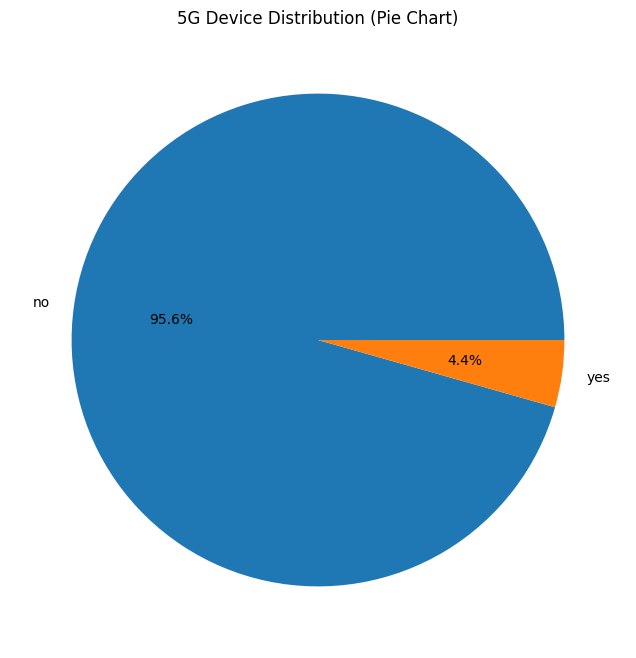

In [16]:
df['5g'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.ylabel('')
plt.title('5G Device Distribution (Pie Chart)')
plt.show()

<Axes: xlabel='count', ylabel='5g'>

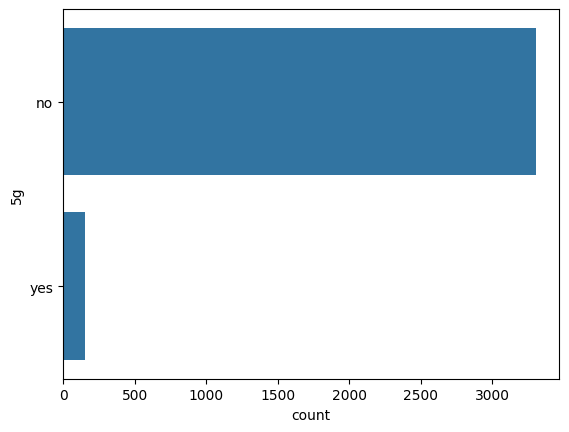

In [17]:
sns.countplot(df['5g'])

<Axes: ylabel='Frequency'>

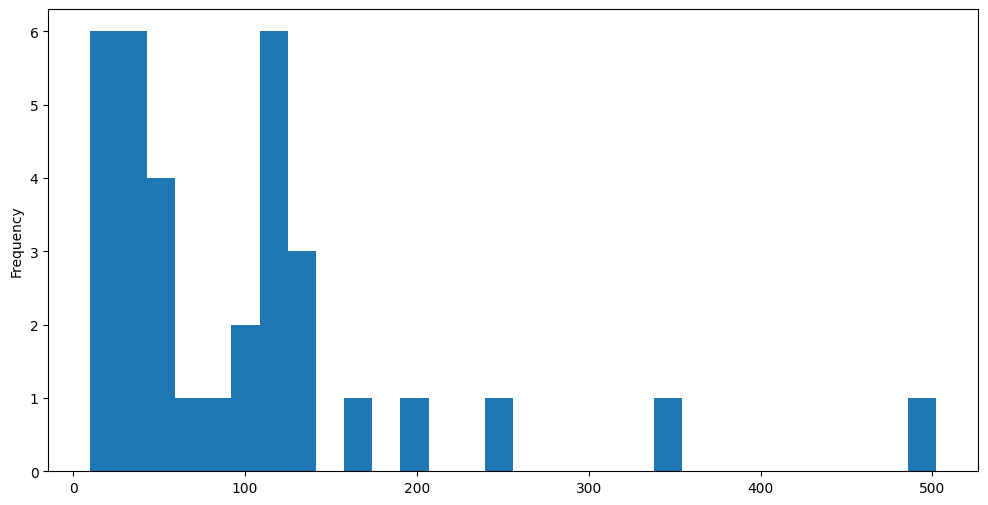

In [18]:
df['device_brand'].value_counts().plot.hist(figsize=(12,6), bins=30)

<Axes: xlabel='ram', ylabel='normalized_used_price'>

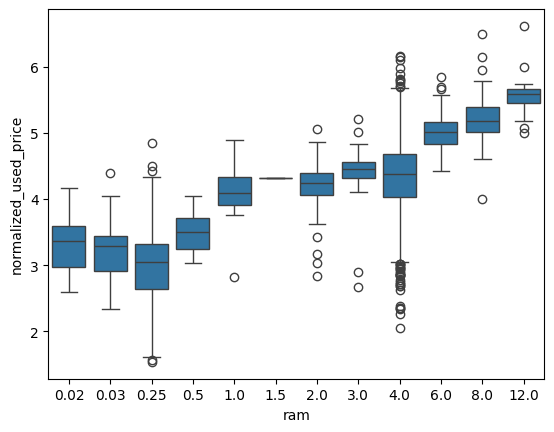

In [19]:
sns.boxplot(x='ram', y='normalized_used_price', data=df)

<Axes: xlabel='ram', ylabel='normalized_used_price'>

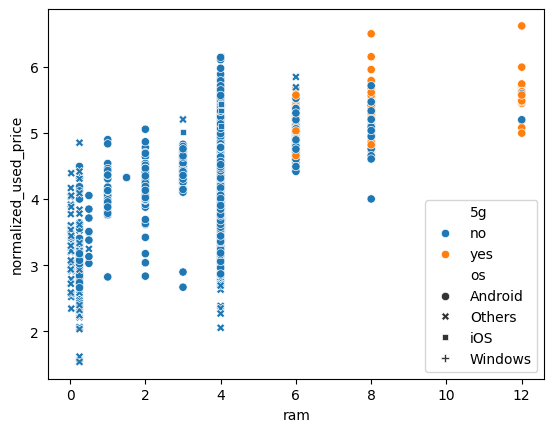

In [20]:
sns.scatterplot(x='ram',y='normalized_used_price',hue='5g',style='os',data=df)

<Axes: xlabel='os', ylabel='normalized_used_price'>

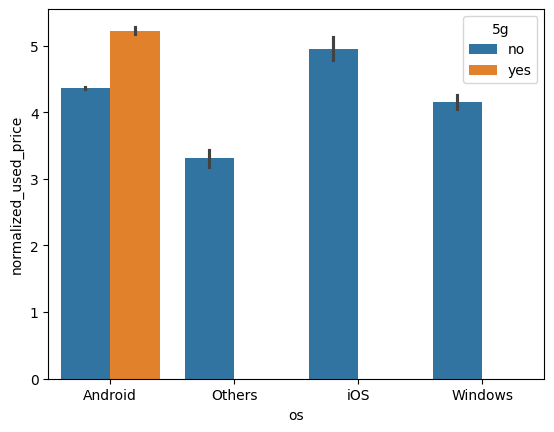

In [21]:
sns.barplot(x='os',y='normalized_used_price',hue='5g',data=df)

In [22]:
df.sample(4)

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
457,Acer,Android,15.24,yes,no,13.0,2.0,16.0,4.0,3300.0,229.0,2013,635,4.631617,5.826914
844,Others,Android,12.70,yes,no,13.0,5.0,16.0,4.0,2800.0,176.0,2017,872,4.132282,4.369954
1459,Lava,Android,10.29,no,no,8.0,2.0,32.0,4.0,2100.0,138.0,2014,607,4.008060,4.581697
3105,ZTE,Android,12.83,yes,no,13.0,13.0,32.0,4.0,5000.0,190.0,2016,793,4.640248,5.433853


<Axes: xlabel='days_used', ylabel='normalized_used_price'>

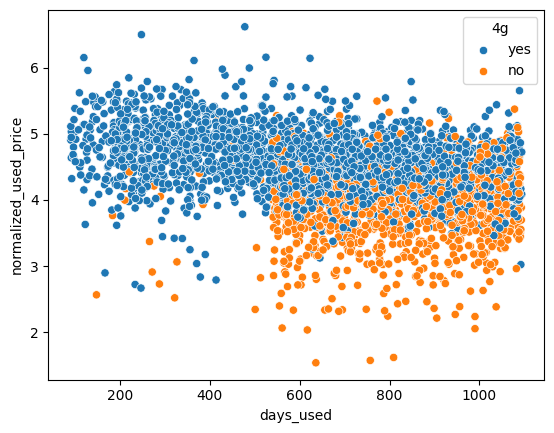

In [23]:
sns.scatterplot(x='days_used',y='normalized_used_price',hue='4g',data=df)

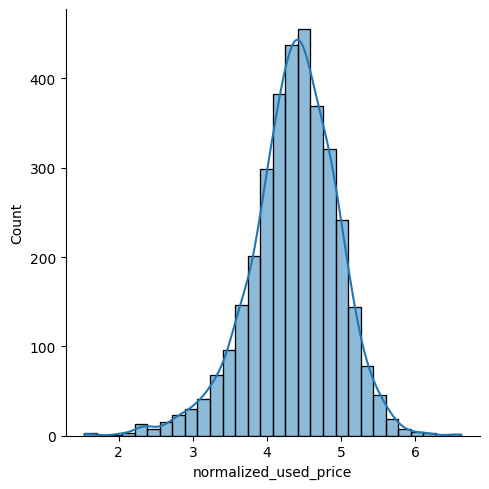

In [24]:
sns.displot(df['normalized_used_price'], kde=True, bins=30)

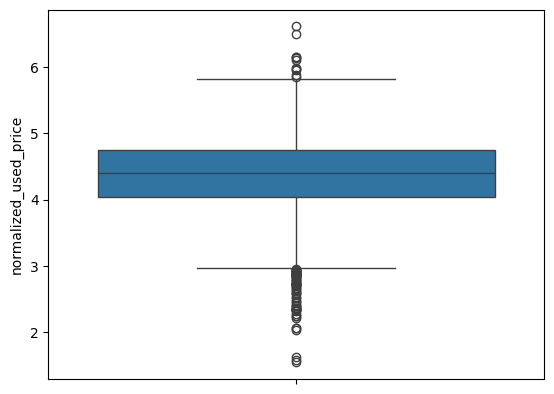

In [25]:
sns.boxplot(df['normalized_used_price'])
plt.show()


In [26]:
df['normalized_used_price'].skew()  

lower = df['normalized_used_price'].quantile(0.05)
upper = df['normalized_used_price'].quantile(0.95)

df['normalized_used_price'] = df['normalized_used_price'].clip(lower, upper)


<Axes: ylabel='normalized_used_price'>

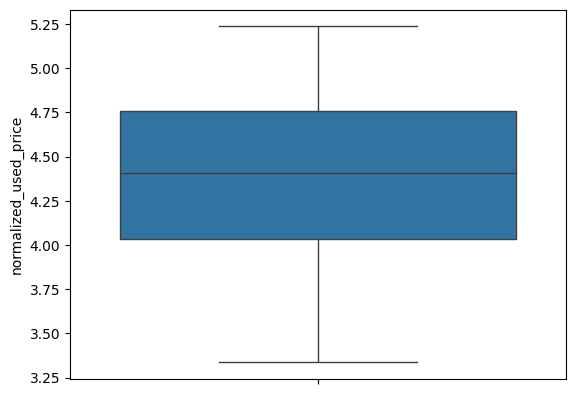

In [27]:
sns.boxplot(df['normalized_used_price'])

In [28]:
df['release_year'].dtype

dtype('int64')

In [29]:
df.describe()

,screen_size,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
count,3454.000000,3275.000000,3452.000000,3450.000000,3450.000000,3448.000000,3447.000000,3454.000000,3454.000000,3454.000000,3454.000000
mean,13.713115,9.460208,6.554229,54.573099,4.036122,3133.402697,182.751871,2015.965258,674.869716,4.373027,5.233107
std,3.805280,4.815461,6.970372,84.972371,1.365105,1299.682844,88.413228,2.298455,248.580166,0.512111,0.683637
min,5.080000,0.080000,0.000000,0.010000,0.020000,500.000000,69.000000,2013.000000,91.000000,3.335414,2.901422
25%,12.700000,5.000000,2.000000,16.000000,4.000000,2100.000000,142.000000,2014.000000,533.500000,4.033931,4.790342
50%,12.830000,8.000000,5.000000,32.000000,4.000000,3000.000000,160.000000,2015.500000,690.500000,4.405133,5.245892
75%,15.340000,13.000000,8.000000,64.000000,4.000000,4000.000000,185.000000,2018.000000,868.750000,4.755700,5.673718
max,30.710000,48.000000,32.000000,1024.000000,12.000000,9720.000000,855.000000,2020.000000,1094.000000,5.236616,7.847841


In [30]:
X= df.drop(columns=['normalized_used_price'])
y= df['normalized_used_price']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [31]:


from category_encoders import OrdinalEncoder, TargetEncoder


categorical_features = ['device_brand', 'os', '4g', '5g']
numerical_features = ['ram', 'internal_memory', 'battery', 'days_used','rear_camera_mp','front_camera_mp','weight','normalized_new_price']

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder()),
    ('scaler', StandardScaler())
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])  

preprocessor = ColumnTransformer(transformers=[
    ('cat_pipeline', categorical_pipeline, categorical_features),
    ('num_pipeline', numerical_pipeline, numerical_features)
])  




In [60]:


from xgboost import XGBRegressor


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
y_pred

print("model_accuracy:", model.score(X_test,y_test))
print("R2_score:", r2_score(y_test,y_pred))
print("MAE:", mean_absolute_error(y_test,y_pred))
print("MSE:", mean_squared_error(y_test,y_pred))

model_accuracy: 0.8346992467553697
R2_score: 0.8346992467553697
MAE: 0.16212525844604544
MSE: 0.04305706378146179


In [52]:
param_distributions = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5, 7],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0],
    'regressor__gamma': [0, 0.1, 0.2],
    'regressor__reg_lambda': [1, 1.5, 2],
    'regressor__reg_alpha': [0, 0.5, 1]
}

In [61]:
# Randomized search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=20,          # number of random combinations
    scoring='r2',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the search
random_search.fit(X_train, y_train)

# Best parameters & score
print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

# Evaluate on test set
y_pred = random_search.predict(X_test)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("\nTest Set Evaluation:")
print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'regressor__subsample': 1.0, 'regressor__reg_lambda': 1.5, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 100, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.1, 'regressor__colsample_bytree': 0.8}
Best CV Score: 0.8433832184954712

Test Set Evaluation:
R2: 0.8588364339083189
MAE: 0.157027342737741
MSE: 0.03676987883916707


In [59]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(random_search, X_train, y_train, cv=5, scoring='r2')
print("CV R² Scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
CV R² Scores: [0.85185874 0.8367028  0.84799665 0.85331901 0.8379796 ]
Mean CV R²: 0.8455713617817645


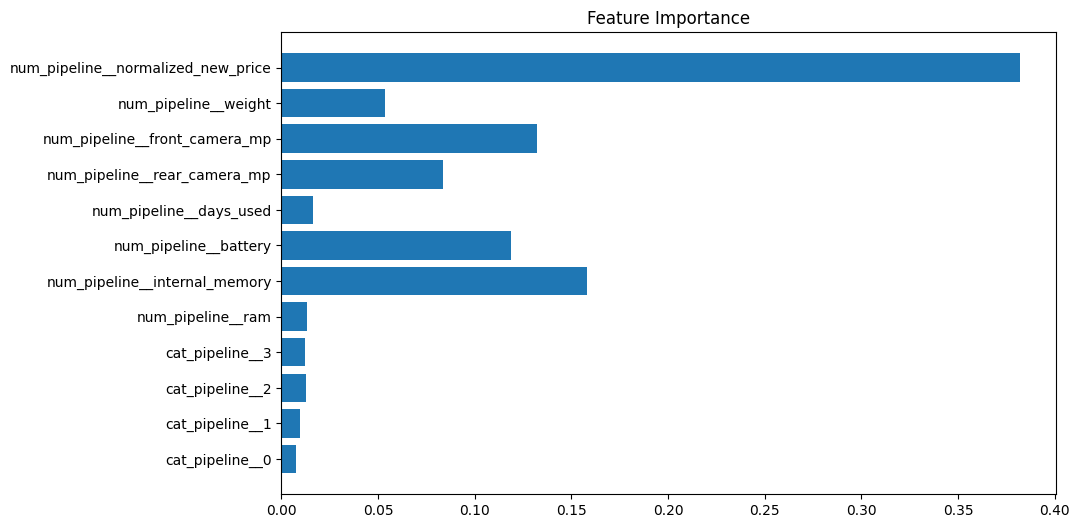

In [63]:
import matplotlib.pyplot as plt

rf = random_search.best_estimator_.named_steps['regressor']
feature_names = random_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
importances = rf.feature_importances_

plt.figure(figsize=(10,6))
plt.barh(feature_names, importances)
plt.title("Feature Importance")
plt.show()
